In [1]:
import os
from sklearn.utils import shuffle
import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import col, split
from pyspark.sql.types import StructField, StructType, FloatType, IntegerType, Row, DoubleType, StringType, ArrayType

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

%matplotlib inline

## 0. Setup

In [2]:
print (pyspark.version)

<module 'pyspark.version' from '/usr/local/lib/python3.6/dist-packages/pyspark/version.py'>


In [3]:
conf = pyspark.SparkConf().setAll([('spark.app.name', 'Spark Data Exploration')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

print (spark.version)
print (pyspark.version)

conf.getAll()

2.3.2
<module 'pyspark.version' from '/usr/local/lib/python3.6/dist-packages/pyspark/version.py'>


dict_items([('spark.app.name', 'Spark Data Exploration')])

## 1. Load and prep data

In [4]:
fpathA = 'ecommerce/customer_reviews_dataset.csv' 
fpathB = 'ecommerce/orders_dataset.csv' 
fpathC = 'ecommerce/geolocation_dataset.csv' 
fpathD = 'ecommerce/order_items_dataset.csv' 
fpathE = 'ecommerce/customers_dataset.csv' 
#fpathF = 'ecommerce/order_payments_dataset.csv' 
fpathG = 'ecommerce/product_category_name_translation.csv' 
fpathH = 'ecommerce/products_dataset.csv' 
fpathI = 'ecommerce/sellers_dataset.csv' 

df_review = spark.read.csv(fpathA, header=True, inferSchema=True).cache()
df_order = spark.read.csv(fpathB, header=True, inferSchema=True).cache()
df_geo = spark.read.csv(fpathC, header=True, inferSchema=True).cache()
df_order_items = spark.read.csv(fpathD, header=True, inferSchema=True).cache()
df_customer = spark.read.csv(fpathE, header=True, inferSchema=True).cache()
#df_order_payment = spark.read.csv(fpathF, header=True, inferSchema=True).cache()
df_cat_translate = spark.read.csv(fpathG, header=True, inferSchema=True).cache()
df_product = spark.read.csv(fpathH, header=True, inferSchema=True).cache()
df_seller = spark.read.csv(fpathI, header=True, inferSchema=True).cache()

In [5]:
# variable selection
df_review = df_review.select(['survey_score', 'order_id'])
df_order = df_order.select(['order_id', 'customer_id'])
df_customer = df_customer.select(['customer_id',  'customer_state'])
df_order_items = df_order_items.select(['order_id', 'product_id', 'price', 'seller_id'])
df_seller = df_seller.select(['seller_id', 'seller_state'])
df_product = df_product.select(['product_id', 'product_category_name', 'product_photos_qty'])
df_cat_translate = df_cat_translate.select(['product_category_name', 'product_category_name_english'])

In [6]:
df_review.show(5)

+------------+--------------------+
|survey_score|            order_id|
+------------+--------------------+
|           4|73fc7af87114b3971...|
|           5|a548910a1c6147796...|
|           5|f9e4b658b201a9f2e...|
|           5|658677c97b385a9be...|
|           5|8e6bfb81e283fa7e4...|
+------------+--------------------+
only showing top 5 rows



In [7]:
# join tables: df_review, df_orders
df_merge = df_review.join(df_order, df_order.order_id == df_review.order_id, 'left_outer').drop(df_order.order_id).dropna(how='any')
df_merge.show(5)
df_merge.count()

+------------+--------------------+--------------------+
|survey_score|            order_id|         customer_id|
+------------+--------------------+--------------------+
|           4|73fc7af87114b3971...|41dcb106f807e9935...|
|           5|a548910a1c6147796...|8a2e7ef9053dea531...|
|           5|f9e4b658b201a9f2e...|e226dfed6544df5b7...|
|           5|658677c97b385a9be...|de6dff97e5f1ba84a...|
|           5|8e6bfb81e283fa7e4...|5986b333ca0d44534...|
+------------+--------------------+--------------------+
only showing top 5 rows



100000

In [8]:
# join tables: temp1, df_customer
df_merge = df_merge.join(df_customer, df_merge.customer_id == df_customer.customer_id, 'left_outer').drop(df_customer.customer_id).dropna(how='any')
df_merge.show(5)
df_merge.count()

+------------+--------------------+--------------------+--------------+
|survey_score|            order_id|         customer_id|customer_state|
+------------+--------------------+--------------------+--------------+
|           4|73fc7af87114b3971...|41dcb106f807e9935...|            SP|
|           5|a548910a1c6147796...|8a2e7ef9053dea531...|            SP|
|           5|f9e4b658b201a9f2e...|e226dfed6544df5b7...|            BA|
|           5|658677c97b385a9be...|de6dff97e5f1ba84a...|            SC|
|           5|8e6bfb81e283fa7e4...|5986b333ca0d44534...|            SC|
+------------+--------------------+--------------------+--------------+
only showing top 5 rows



100000

In [9]:
# join tables: temp1, df_order_items
df_merge = df_merge.join(df_order_items, df_merge.order_id == df_order_items.order_id, 'left_outer').drop(df_order_items.order_id).dropna(how='any')
df_merge.show(5)
df_merge.count()

+------------+--------------------+--------------------+--------------+--------------------+------+--------------------+
|survey_score|            order_id|         customer_id|customer_state|          product_id| price|           seller_id|
+------------+--------------------+--------------------+--------------+--------------------+------+--------------------+
|           5|014405982914c2cde...|2de342d6e5905a5a8...|            RJ|6782d593f63105318...|  27.9|325f3178fb58e2a97...|
|           5|014405982914c2cde...|2de342d6e5905a5a8...|            RJ|e95ee6822b66ac605...| 21.33|a17f621c590ea0fab...|
|           5|019886de8f385a39b...|8cf88d7ba142365ef...|            MS|e9a69340883a438c3...| 159.9|1b4c3a6f53068f0b6...|
|           3|01a6ad782455876aa...|71accffbcbdf8e02f...|            RS|036734b5a58d5d4f4...| 34.99|ea8482cd71df3c196...|
|           5|01d907b3e209269e1...|d02cc92f5e33eb58d...|            SP|b1434a8f79cb35285...|151.99|d1c281d3ae1492323...|
+------------+------------------

113322

In [10]:
# join tables: temp1, df_seller
df_merge = df_merge.join(df_seller, df_merge.seller_id == df_seller.seller_id, 'left_outer').drop(df_seller.seller_id).dropna(how='any')
df_merge.show(5)
df_merge.count()

+------------+--------------------+--------------------+--------------+--------------------+------+--------------------+------------+
|survey_score|            order_id|         customer_id|customer_state|          product_id| price|           seller_id|seller_state|
+------------+--------------------+--------------------+--------------+--------------------+------+--------------------+------------+
|           5|014405982914c2cde...|2de342d6e5905a5a8...|            RJ|6782d593f63105318...|  27.9|325f3178fb58e2a97...|          SP|
|           5|014405982914c2cde...|2de342d6e5905a5a8...|            RJ|e95ee6822b66ac605...| 21.33|a17f621c590ea0fab...|          SP|
|           5|019886de8f385a39b...|8cf88d7ba142365ef...|            MS|e9a69340883a438c3...| 159.9|1b4c3a6f53068f0b6...|          SC|
|           3|01a6ad782455876aa...|71accffbcbdf8e02f...|            RS|036734b5a58d5d4f4...| 34.99|ea8482cd71df3c196...|          SP|
|           5|01d907b3e209269e1...|d02cc92f5e33eb58d...|      

113322

In [11]:
# join tables: temp1, df_product
df_merge = df_merge.join(df_product, df_merge.product_id == df_product.product_id, 'left_outer').drop(df_product.product_id).dropna(how='any')
df_merge.show(5)
df_merge.count()

+------------+--------------------+--------------------+--------------+--------------------+------+--------------------+------------+---------------------+------------------+
|survey_score|            order_id|         customer_id|customer_state|          product_id| price|           seller_id|seller_state|product_category_name|product_photos_qty|
+------------+--------------------+--------------------+--------------+--------------------+------+--------------------+------------+---------------------+------------------+
|           5|014405982914c2cde...|2de342d6e5905a5a8...|            RJ|6782d593f63105318...|  27.9|325f3178fb58e2a97...|          SP|           perfumaria|                 1|
|           5|014405982914c2cde...|2de342d6e5905a5a8...|            RJ|e95ee6822b66ac605...| 21.33|a17f621c590ea0fab...|          SP|        esporte_lazer|                 1|
|           5|019886de8f385a39b...|8cf88d7ba142365ef...|            MS|e9a69340883a438c3...| 159.9|1b4c3a6f53068f0b6...|     

111710

In [12]:
# join tables: temp1, df_cat_translate
df_merge = df_merge.join(df_cat_translate, df_merge.product_category_name == df_cat_translate.product_category_name, 'left_outer')\
.drop(df_cat_translate.product_category_name).dropna(how='any')
# final table
df_merge.show(5)
df_merge.count()

+------------+--------------------+--------------------+--------------+--------------------+------+--------------------+------------+---------------------+------------------+-----------------------------+
|survey_score|            order_id|         customer_id|customer_state|          product_id| price|           seller_id|seller_state|product_category_name|product_photos_qty|product_category_name_english|
+------------+--------------------+--------------------+--------------+--------------------+------+--------------------+------------+---------------------+------------------+-----------------------------+
|           5|014405982914c2cde...|2de342d6e5905a5a8...|            RJ|6782d593f63105318...|  27.9|325f3178fb58e2a97...|          SP|           perfumaria|                 1|                    perfumery|
|           5|014405982914c2cde...|2de342d6e5905a5a8...|            RJ|e95ee6822b66ac605...| 21.33|a17f621c590ea0fab...|          SP|        esporte_lazer|                 1|      

111686

## Describe data
### To include: data quality issues, characteristics of the dataset (summary statistics, correlation, outliers, etc.)

In [13]:
df_merge.printSchema()

root
 |-- survey_score: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- price: double (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- seller_state: string (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_photos_qty: integer (nullable = true)
 |-- product_category_name_english: string (nullable = true)



## Describe data preparation process

### To include: features used, train and test datasets

In [18]:
sel_cols = ['survey_score', 'price', 'product_category_name_english', 'product_photos_qty']
df_selected = df_merge.select(sel_cols)
# transform survey_score to numeric
from pyspark.sql.types import IntegerType
df_merge = df_merge.withColumn("survey_score", df_merge["survey_score"].cast(IntegerType())).dropna(how='any')
df_selected.printSchema()


def null_percent(df, columns=None):
    """
    Prints a sorted list of tuples (col_name, percent_null)
    If you pass a list of column names, it'll only look for nulls in those specified.
    Otherwise, it'll check all columns
    """
    # calculate for all columns if none specified
    if columns is None:
        columns = df.columns
        
    n_samples = df.count()
    
    # a lambda for calculating percent, and another to format this value
    percent_col_null = lambda colname: f.count(f.when(f.isnull(colname), colname)) * 100 / n_samples
    percent_formatted = lambda colname: f.format_string("%2.4f", percent_col_null(colname))

    # use our lambdas to get a dict of columns and their null percentage
    null_counts = df.select([percent_formatted(c).alias(c) for c in columns]).collect()[0].asDict()
    sorted_counts = sorted([(k,v) for k,v in null_counts.items()], key=lambda tup: float(tup[1]))

    print ('% Null')
    for (colname, percent) in sorted_counts:
        print(colname + ': ' + percent)
    

null_percent(df_selected) 
df_selected.count()

root
 |-- survey_score: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- product_category_name_english: string (nullable = true)
 |-- product_photos_qty: integer (nullable = true)

% Null
survey_score: 0.0000
price: 0.0000
product_category_name_english: 0.0000
product_photos_qty: 0.0000


111686

In [19]:
from pyspark.ml.feature import VectorAssembler

df = df_selected.select(['survey_score', 'price','product_photos_qty', 'product_category_name_english'])

# Create a vector column composed of all the features
feature_cols = ['survey_score',
 'price',
 'product_photos_qty']

other_cols = ['product_category_name_english']

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features_unscaled')
features_df = assembler.transform(df)

features_df.show(5)

+------------+------+------------------+-----------------------------+-----------------+
|survey_score| price|product_photos_qty|product_category_name_english|features_unscaled|
+------------+------+------------------+-----------------------------+-----------------+
|           5|  27.9|                 1|                    perfumery|   [5.0,27.9,1.0]|
|           5| 21.33|                 1|               sports_leisure|  [5.0,21.33,1.0]|
|           5| 159.9|                 5|                   housewares|  [5.0,159.9,5.0]|
|           3| 34.99|                 5|                    telephony|  [3.0,34.99,5.0]|
|           5|151.99|                 1|               bed_bath_table| [5.0,151.99,1.0]|
+------------+------+------------------+-----------------------------+-----------------+
only showing top 5 rows



In [20]:
from pyspark.ml.stat import Correlation

# Get correlation DataFrame, collect and extract a pyspark.mllib.linalg.DenseMatrix, convert to array 
corr_mat = Correlation.corr(features_df, 'features_unscaled').collect()[0][0].toArray()

In [21]:
# Create Pandas DataFrame from correlation matrix
corr_mat = pd.DataFrame(corr_mat, index=feature_cols, columns=feature_cols)
corr_mat.head(len(feature_cols))

,survey_score,price,product_photos_qty
survey_score,1.000000,-0.005109,0.022603
price,-0.005109,1.000000,0.051734
product_photos_qty,0.022603,0.051734,1.000000


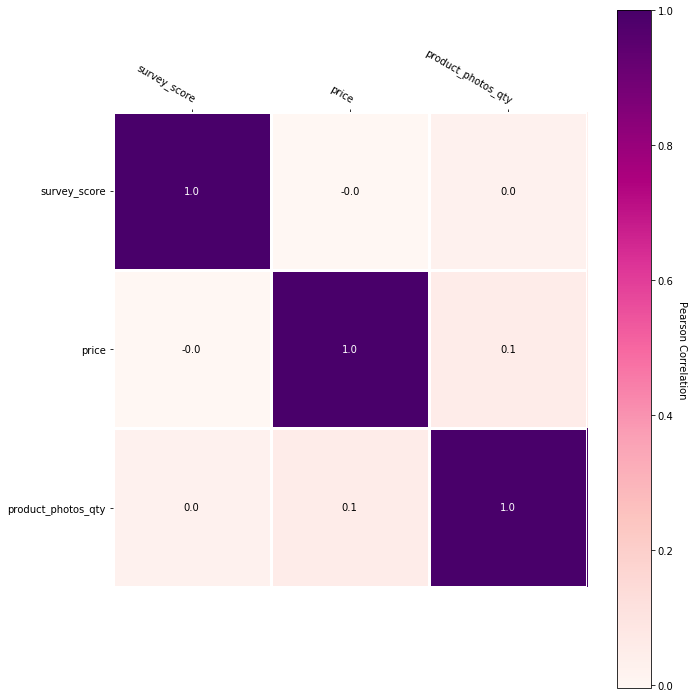

In [22]:
import utils

fig, ax = plt.subplots(figsize=(10,10))

im, cbar = utils.heatmap(corr_mat, feature_cols, feature_cols, ax=ax,
                         cmap="RdPu", cbarlabel="Pearson Correlation")

texts = utils.annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

## Describe model

### To include: input, setup, and output

In [23]:
train_df, test_df = features_df.randomSplit([0.75, 0.25], seed=12345)
train_df.count(), test_df.count()

(83464, 28222)

In [24]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(train_df)

train_df = scalerModel.transform(train_df)
test_df = scalerModel.transform(test_df)

train_df.show(5)      
test_df.show(5)        

+------------+-----+------------------+-----------------------------+-----------------+--------------------+
|survey_score|price|product_photos_qty|product_category_name_english|features_unscaled|            features|
+------------+-----+------------------+-----------------------------+-----------------+--------------------+
|           1| 10.9|                 2|                   housewares|   [1.0,10.9,2.0]|[-2.1602277381078...|
|           1| 12.9|                 1|               home_comfort_2|   [1.0,12.9,1.0]|[-2.1602277381078...|
|           1| 29.9|                 3|         computers_accesso...|   [1.0,29.9,3.0]|[-2.1602277381078...|
|           1| 29.9|                 3|         computers_accesso...|   [1.0,29.9,3.0]|[-2.1602277381078...|
|           1|29.99|                 5|         fashion_bags_acce...|  [1.0,29.99,5.0]|[-2.1602277381078...|
+------------+-----+------------------+-----------------------------+-----------------+--------------------+
only showing top 5 

Trying k from 3 to 7 with 41543 samples...

Training for cluster size 3 
......................WSSE = 36735.85973375827 
Training for cluster size 4 
......................WSSE = 33873.066177577784 
Training for cluster size 5 
......................WSSE = 30932.92333671759 
Training for cluster size 6 
......................WSSE = 29771.57655807155 
Training for cluster size 7 
......................WSSE = 28624.918133071184 


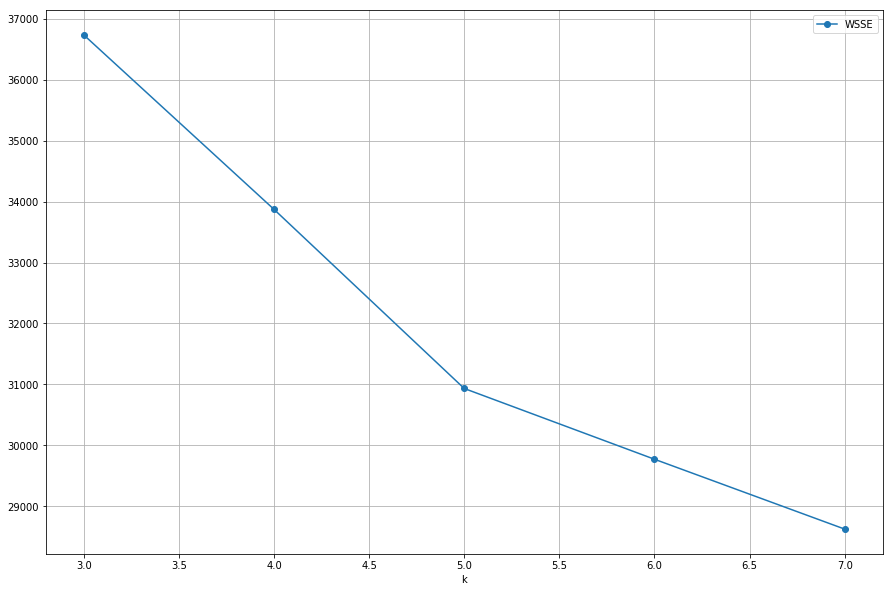

In [25]:
# Only need to run this once to find value(s) to try for k
create_elbow_plot = True # Set to False if already know value for k

if create_elbow_plot == True:
    # lower the sample fraction to decrease fit time (with the risk of worse results)
    sampled = train_df.sample(.5)

    k_attempts = range(3,8)
    print('Trying k from {} to {} with {} samples...\n'.format(list(k_attempts)[0],
                                                               list(k_attempts)[-1],
                                                               sampled.count()))

    wsseList = utils.elbow(sampled, k_attempts)
    utils.elbow_plot(wsseList, k_attempts)

In [26]:
from pyspark.ml.clustering import KMeans

K = 5
kmeans = KMeans(k=K, seed=42)
model = kmeans.fit(train_df)

In [27]:
# Compute WSSSE, though it isn't necessarily the best indicator of performance
train_wssse = model.computeCost(train_df)
test_wssse = model.computeCost(test_df)

# Test WSSSE will naturally be lower, as the test set has less samples
print("Train WSSSE = {}".format(train_wssse))
print("Test WSSSE = {}".format(test_wssse))

Train WSSSE = 77836.5966013004
Test WSSSE = 24790.843064983692


In [28]:
train_preds_df = model.transform(train_df)
test_preds_df = model.transform(test_df)

test_preds_df.show(5)

+------------+-----+------------------+-----------------------------+-----------------+--------------------+----------+
|survey_score|price|product_photos_qty|product_category_name_english|features_unscaled|            features|prediction|
+------------+-----+------------------+-----------------------------+-----------------+--------------------+----------+
|           1|29.99|                 2|                         auto|  [1.0,29.99,2.0]|[-2.1602277381078...|         0|
|           1| 38.4|                 1|              furniture_decor|   [1.0,38.4,1.0]|[-2.1602277381078...|         0|
|           1| 38.4|                 1|              furniture_decor|   [1.0,38.4,1.0]|[-2.1602277381078...|         0|
|           1| 45.0|                 1|              furniture_decor|   [1.0,45.0,1.0]|[-2.1602277381078...|         0|
|           1| 48.0|                 3|         computers_accesso...|   [1.0,48.0,3.0]|[-2.1602277381078...|         0|
+------------+-----+------------------+-

In [29]:
cluster_centers = model.clusterCenters()

# Convert list of centers to Pandas DataFrame. 
# Rows will be the cluster centers, columns will be the features
centers_df_pd = utils.pd_centers(feature_cols, cluster_centers)
centers_df_pd.head(len(cluster_centers))

,survey_score,price,product_photos_qty,prediction
0,-2.010297,-0.103915,-0.252801,0
1,0.702185,-0.126313,-0.402383,1
2,0.048108,4.813576,0.232346,2
3,-0.235090,-0.132136,-0.398457,3
4,0.244829,-0.074261,1.817941,4


In [30]:
from pyspark.ml.linalg import Vectors, VectorUDT, Vector

# Use a user defined function to map centroid list to a pyspark Vector
# The outer function is for passing in the mapping so the UDF may access it
# The inner function returns the UDF object and specifies its return type 
def get_centroid(mapping):
    def get_centroid_(col):
        return Vectors.dense(mapping.get(col))
    return f.udf(get_centroid_, VectorUDT())

# dictionary for mapping cluster ID to it's centroid in latent space
centers_map = {i: list(cluster_centers[i]) for i in range(K)}

In [31]:
# add 'centroid' column to train and test dataframes using UDF above
train_preds_df = train_preds_df.withColumn("centroid", get_centroid(centers_map)(f.col("prediction")))
test_preds_df = test_preds_df.withColumn("centroid", get_centroid(centers_map)(f.col("prediction")))

test_preds_df.select(['features', 'prediction', 'centroid']).show(5)

+--------------------+----------+--------------------+
|            features|prediction|            centroid|
+--------------------+----------+--------------------+
|[-2.1602277381078...|         0|[-2.0102972238199...|
|[-2.1602277381078...|         0|[-2.0102972238199...|
|[-2.1602277381078...|         0|[-2.0102972238199...|
|[-2.1602277381078...|         0|[-2.0102972238199...|
|[-2.1602277381078...|         0|[-2.0102972238199...|
+--------------------+----------+--------------------+
only showing top 5 rows



## Describe analysis results and insights gained

### To include: discussion of results, actionable insights 

In [32]:
from pyspark.sql.types import FloatType
from scipy.spatial import distance

# Create a UDF to compute a new distance column
def compute_distance(sample, center):
    return float(distance.euclidean(sample, center))

distance_udf = f.udf(compute_distance, FloatType())

In [33]:
# Add column containing Euclidean distance from each point to its assigned cluster center

train_preds_df = train_preds_df.withColumn('distance',
                                           distance_udf(f.col('features'), f.col('prediction')))

test_preds_df = test_preds_df.withColumn('distance', 
                                         distance_udf(f.col('features'), f.col('prediction')))

test_preds_df.select(['features', 'prediction', 'centroid', 'distance']).show(5)

+--------------------+----------+--------------------+---------+
|            features|prediction|            centroid| distance|
+--------------------+----------+--------------------+---------+
|[-2.1602277381078...|         0|[-2.0102972238199...|2.2186656|
|[-2.1602277381078...|         0|[-2.0102972238199...|2.3150191|
|[-2.1602277381078...|         0|[-2.0102972238199...|2.3150191|
|[-2.1602277381078...|         0|[-2.0102972238199...|2.3083992|
|[-2.1602277381078...|         0|[-2.0102972238199...|2.2429996|
+--------------------+----------+--------------------+---------+
only showing top 5 rows



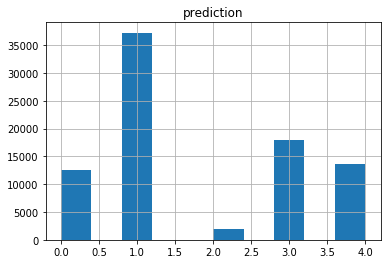

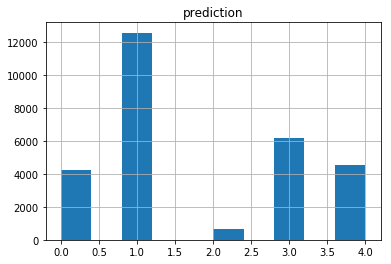

In [34]:
train_preds_df.select("prediction").toPandas().hist()
test_preds_df.select("prediction").toPandas().hist(); # semi-colon supresses ugly return val output

In [35]:
def pyspark_to_pandas(df, feature_names, vector_column='features', keep_columns=[]):
    """
    Takes a pyspark dataframe and converts it to a pandas dataframe,
    unpacking values from a specified Vector column into their own columns.
    
    args:
        df            -- The Pyspark DataFrame to convert
        feature_names -- List of column names corresponding to the values in
                         the vector_column to be unpacked
        vector_column -- the name of the column in the DataFrame containing
                         the vector to unpack (typically 'features')
        keep_columns  -- List of column names that you want to include in the
                         Pandas DataFrame (other than the vector_column, which 
                         is implied)
    returns: 
        A Pandas DataFrame containing all values from the 'vector_column' and 
        'keep_columns' from the given PySpark datataframe
        
    """
    
    def vector_to_array(col):
        def to_array_(v):
            return v.toArray().tolist()
        return f.udf(to_array_, ArrayType(DoubleType()))(col)

    # select columns to keep, typically keep_columns + 'features'
    keep_columns = keep_columns[:] + [vector_column]
    df = df.select(keep_columns)

    # transform Vector column into Array column (so we can break it up)
    df = df.withColumn("feat_array", vector_to_array(f.col("features"))).drop('features')

    # remove "features" column name from our list of columns to keep, since we dropped it above
    keep_columns.remove('features')
    
    # break up the array values into their own column, also keeping keep_columns around
    n_feat = len(feature_names)
    array_columns = [df["feat_array"][i] for i in range(n_feat)]
    
    clustered_data_pd = df.select(keep_columns + array_columns).toPandas()
    
    
    # give names to the pandas df columns and return
    clustered_data_pd.columns = keep_columns + feature_names
    
    print('Created Pandas DataFrame with columns:\n\t{}'.format(clustered_data_pd.columns.tolist()))
    return clustered_data_pd

In [36]:
keep_columns = ['product_category_name_english', 'prediction', 'distance', 'centroid']

train_df_pd = pyspark_to_pandas(train_preds_df, feature_cols, 'features', keep_columns)
test_df_pd = pyspark_to_pandas(test_preds_df, feature_cols, 'features', keep_columns)

test_df_pd.head()

Created Pandas DataFrame with columns:
	['product_category_name_english', 'prediction', 'distance', 'centroid', 'survey_score', 'price', 'product_photos_qty']
Created Pandas DataFrame with columns:
	['product_category_name_english', 'prediction', 'distance', 'centroid', 'survey_score', 'price', 'product_photos_qty']


,product_category_name_english,prediction,distance,centroid,survey_score,price,product_photos_qty
0,auto,0,2.218666,"[-2.0102972238199524, -0.10391499642692398, -0...",-2.160228,-0.490799,-0.122515
1,furniture_decor,0,2.315019,"[-2.0102972238199524, -0.10391499642692398, -0...",-2.160228,-0.445159,-0.703252
2,furniture_decor,0,2.315019,"[-2.0102972238199524, -0.10391499642692398, -0...",-2.160228,-0.445159,-0.703252
3,furniture_decor,0,2.308399,"[-2.0102972238199524, -0.10391499642692398, -0...",-2.160228,-0.409341,-0.703252
4,computers_accessories,0,2.243000,"[-2.0102972238199524, -0.10391499642692398, -0...",-2.160228,-0.393060,0.458221


/home/jovyan/Desktop/MGTA495/W 10:11 - Final Project/utils.py:66: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  parallel_coordinates(data, 'prediction', color = my_colors, marker='o')


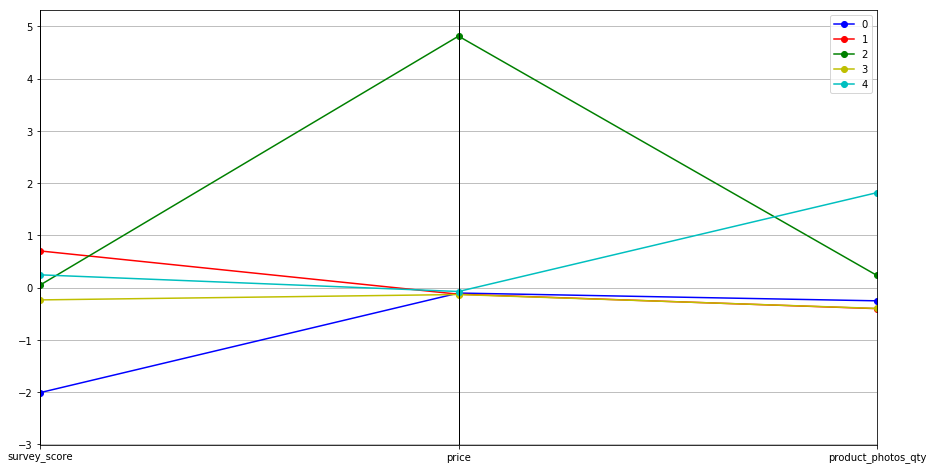

In [37]:
# adjust the y-axis range to fit our clusters
y_min = np.min(centers_df_pd.values.tolist()) - 1
y_max = np.max(centers_df_pd.values.tolist()) + 0.5
y_lim = [y_min, y_max]

cluster_colors = utils.parallel_plot(centers_df_pd, centers_df_pd, ylim=y_lim)



----- 4231 samples in cluster 0 -----


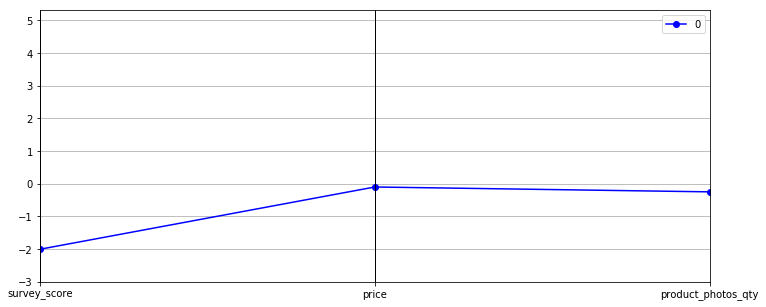

<Figure size 792x288 with 0 Axes>



----- 12595 samples in cluster 1 -----


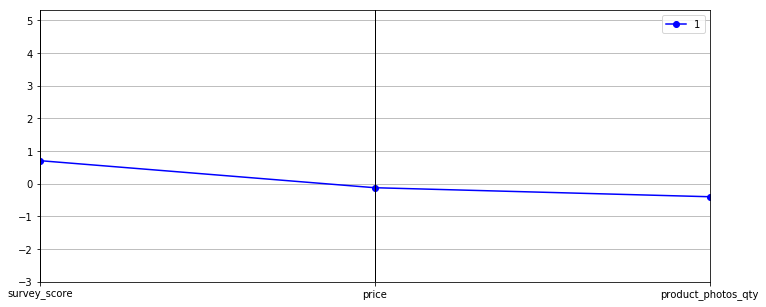

<Figure size 792x288 with 0 Axes>



----- 674 samples in cluster 2 -----


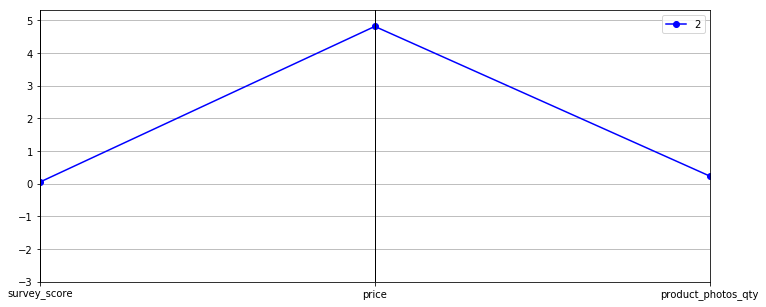

<Figure size 792x288 with 0 Axes>



----- 6179 samples in cluster 3 -----


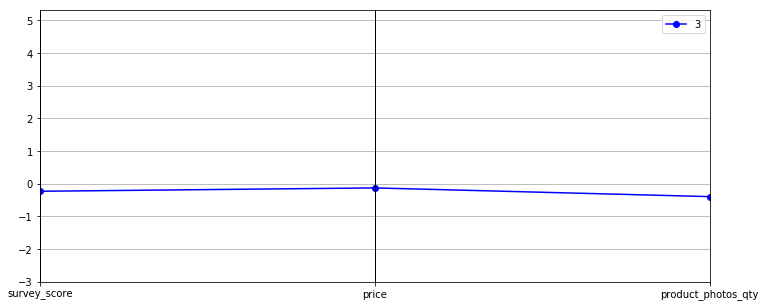

<Figure size 792x288 with 0 Axes>



----- 4543 samples in cluster 4 -----


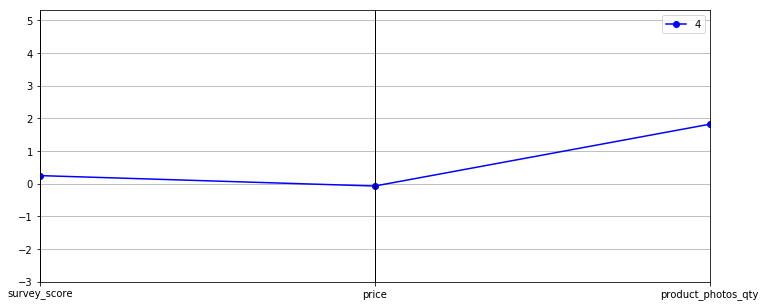

<Figure size 792x288 with 0 Axes>

In [38]:
# you may need to change these based on what features you chose
analysis_cols = ['price', 'survey_score', 'product_photos_qty'] 

for cluster_id in range(len(cluster_centers)):

    # select samples from within current cluster
    within_cluster = test_preds_df.filter(f.col('prediction') == cluster_id)
    
    # select desired columns for analysis, convert to pandas
    within_cluster = within_cluster.select(analysis_cols).toPandas()
    
    print('\n\n----- {} samples in cluster {} -----'.format(len(within_cluster), cluster_id))

    # plot the centroid for current cluster
    center = centers_df_pd[centers_df_pd['prediction'] == cluster_id]
    
    utils.parallel_plot(center, centers_df_pd, ylim=y_lim, figsize=(12,5))
    plt.figure(figsize=(11,4))
    plt.show()

In [39]:
spark.stop()

### Discussion of Results:
1. Based on the elbow plot, we can see 5 clusters would be the most ideal choice because it was the point right before the diminishing return of adding more clusters kicks in.

2. Based on the centroid prediction and cluster plot, we can see the biggest cluster is the No.1 cluster in the red line with the highest survey score and normal price level as well as relatively lower picture quantity.

3. The smallest cluster is the No. 2 cluster in the green line with the significantly higher price and normal level of survey score and picture quantity.

### Actionable Insights:
1. If higher-priced products can lead to more profit to the company, it would be recommended to increase the number of higher-priced products (featured in cluster No.2).

2. There is a group of obviously lower-rated products featured in cluster No.0 that would be worthy of further investigation with other additional numeric features to make systematic improvements.
